<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [3]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical

In [4]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [5]:
from keras import backend

def wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

In [6]:
from keras.constraints import Constraint

class ClipConstraint(Constraint):
  def __init__(self, clip_value):
    self.clip_value = clip_value

  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)

  def get_config(self):
    return {'clip_value': self.clip_value}

wasserstein_constraint = ClipConstraint(0.01)

In [7]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

AUDIO_LENGTH = 110250

def build_critic(input_shape=[AUDIO_LENGTH, 1]):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=7, strides=5,
             kernel_constraint=wasserstein_constraint, padding='same')(X_input)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(64, kernel_size=7, strides=5,
             kernel_constraint=wasserstein_constraint, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(32, kernel_size=3, strides=3,
             kernel_constraint=wasserstein_constraint, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Flatten()(y)
  y = Dense(1, activation='linear')(y)

  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [8]:
from tensorflow.keras.optimizers import RMSprop

critic = build_critic()
critic.compile(loss=wasserstein_loss, optimizer=RMSprop(lr=0.00005), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 110250, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 22050, 128)        1024      
                                                                 
 batch_normalization (BatchN  (None, 22050, 128)       512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 22050, 128)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4410, 64)          57408     
                                                                 
 batch_normalization_1 (Batc  (None, 4410, 64)         256       
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [9]:
from keras.layers.convolutional import Conv1DTranspose
from keras.layers import Reshape

LATENT_DIM = 98

def build_generator(input_shape=(LATENT_DIM, )):

  X_input = Input(input_shape)
  
  y = Dense(input_shape[0] * 128)(X_input)
  y = Reshape((input_shape[0], 128))(y)
  y = BatchNormalization()(y)
  y = Conv1DTranspose(128, kernel_size=3, strides=3, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=3, strides=3, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(64, kernel_size=7, strides=5, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(64, kernel_size=7, strides=5, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(64, kernel_size=7, strides=5, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(1, kernel_size=3, padding='same', activation='tanh')(y)


  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [10]:
generator = build_generator()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_1 (Dense)             (None, 12544)             1241856   
                                                                 
 reshape (Reshape)           (None, 98, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 98, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_transpose (Conv1DTra  (None, 294, 128)         49280     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 294, 128)         512 

In [11]:
z = Input(shape=(LATENT_DIM,))
sample = generator(z)
critic.trainable = False
valid = critic(sample)
combined_model = Model(z, valid)
combined_model.compile(loss=wasserstein_loss, optimizer=RMSprop(lr=0.00005))
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98)]              0         
                                                                 
 model_1 (Functional)        (None, 110250, 1)         1457793   
                                                                 
 model (Functional)          (None, 1)                 112545    
                                                                 
Total params: 1,570,338
Trainable params: 1,456,641
Non-trainable params: 113,697
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
from numpy.random import default_rng

rng = default_rng()

batch_size = 32
half_batch = int(batch_size / 2)
n_steps = 16 * 5
n_critic = 5

real_labels = -np.ones((batch_size, 1))
fake_labels = np.ones((batch_size, 1))

DATASET_PATH = './audio_splitting/genres/jazz'
SAMPLES_LIST = os.listdir(DATASET_PATH)
SAMPLES_NUM = len(SAMPLES_LIST)
d_loss_history = []
d_acc_history = []
g_loss_history = []

In [13]:
batches_num = int(SAMPLES_NUM/half_batch)

for step in range(n_steps):
  d_loss_sum = 0
  d_acc_sum = 0

  for critic_step in range(n_critic):
    batch_idx = rng.choice(SAMPLES_NUM, size=half_batch)
    
    real_samples, _ = get_data([
        os.path.join(DATASET_PATH, SAMPLES_LIST[i]) for i in batch_idx
      ])
    
    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
    gen_samples = generator.predict(noise[0:half_batch])

    d_loss_real = critic.train_on_batch(real_samples, real_labels[0:half_batch])
    d_loss_fake = critic.train_on_batch(gen_samples, fake_labels[0:half_batch])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_loss_sum += d_loss[0]
    d_acc_sum += d_loss[1]

  g_loss = combined_model.train_on_batch(noise, real_labels)

  d_loss_history.append(d_loss_sum/n_critic)
  g_loss_history.append(g_loss)
  d_acc_history.append(100*d_acc_sum/n_critic)
  
  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
    % (step, d_loss_sum/n_critic, 100*d_acc_sum/n_critic, g_loss))

0 [D loss: -1.000816, acc.: 0.00%] [G loss: -0.027076]
1 [D loss: -2.558409, acc.: 0.00%] [G loss: -0.058547]
2 [D loss: -4.219911, acc.: 0.00%] [G loss: -0.101444]
3 [D loss: -5.745724, acc.: 0.00%] [G loss: -0.156379]
4 [D loss: -7.639017, acc.: 0.00%] [G loss: -0.234599]
5 [D loss: -9.248163, acc.: 0.00%] [G loss: -0.323863]
6 [D loss: -10.643145, acc.: 0.00%] [G loss: -0.434470]
7 [D loss: -12.698095, acc.: 0.00%] [G loss: -0.579683]
8 [D loss: -14.184715, acc.: 0.00%] [G loss: -0.747379]
9 [D loss: -16.280625, acc.: 1.88%] [G loss: -0.942210]
10 [D loss: -18.364073, acc.: 1.25%] [G loss: -1.164633]
11 [D loss: -20.239671, acc.: 1.88%] [G loss: -1.406460]
12 [D loss: -21.984779, acc.: 1.25%] [G loss: -1.676814]
13 [D loss: -24.958735, acc.: 0.00%] [G loss: -1.949651]
14 [D loss: -26.836440, acc.: 1.25%] [G loss: -2.280140]
15 [D loss: -28.968344, acc.: 0.00%] [G loss: -2.645200]
16 [D loss: -30.320784, acc.: 0.00%] [G loss: -3.023952]
17 [D loss: -33.361674, acc.: 0.00%] [G loss: -

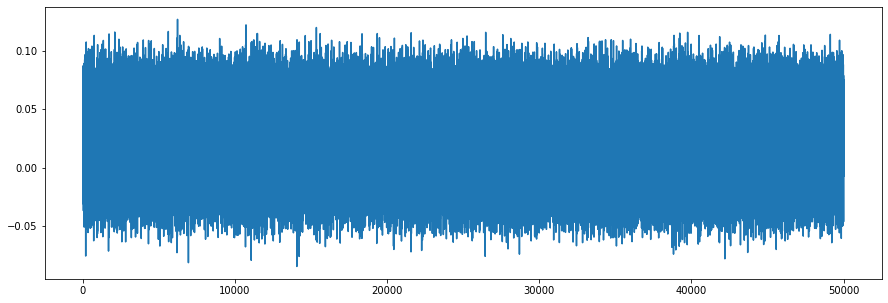

In [14]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (1, LATENT_DIM))
gen_sample = generator.predict(noise)
gen_sample = gen_sample.reshape(AUDIO_LENGTH, 1)

plt.figure(figsize=(15,5))
plt.plot(gen_sample[50100 : 100100])
plt.show()
#plt.savefig('gen_sample_wgan' + str(len(g_loss_history)))

In [15]:
generator.save('generator_wgan.h5')
critic.save('critic_wgan.h5')

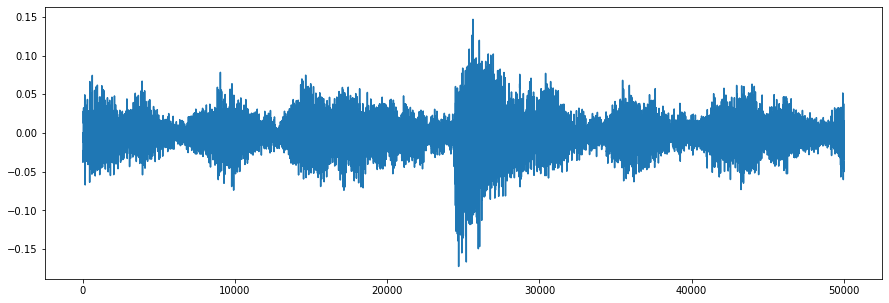

In [16]:
with open(DATASET_PATH + '/3000.pkl', 'rb') as f:
      pkl_file = pickle.load(f)
      plt.figure(figsize=(15,5))
      plt.plot(pkl_file['audio'][50100 : 100100])
      plt.show()


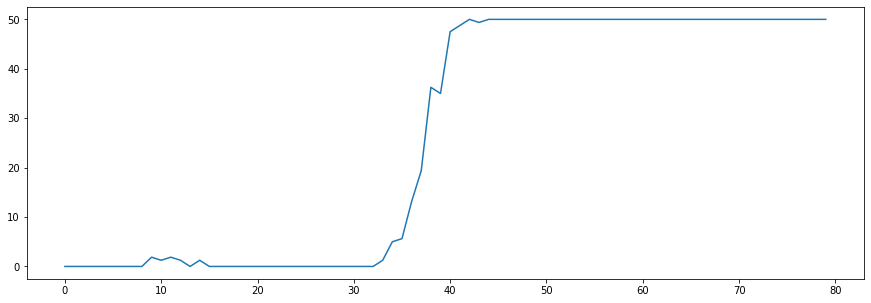

In [17]:
plt.figure(figsize=(15,5))
plt.plot(d_acc_history)

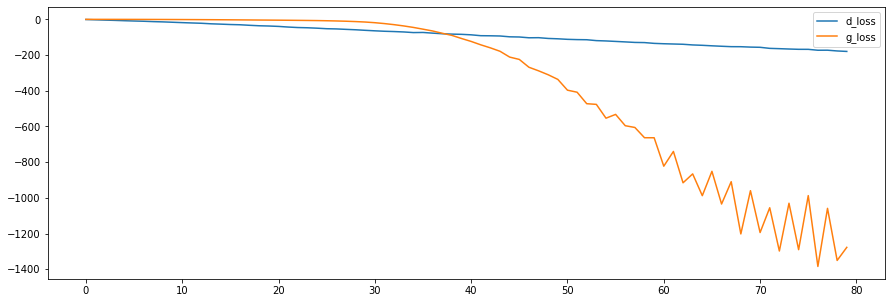

In [18]:
plt.figure(figsize=(15,5))
plt.plot(d_loss_history, label='d_loss')
plt.plot(g_loss_history, label='g_loss')
plt.legend()